In [1]:
%matplotlib notebook

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years, find_citation
from snowballing.strategies import Strategy, State
import custom_strategies
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import pandas as pd
from collections import OrderedDict
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

custom_strategies.LIMIT_YEAR = 2015
reload()
# !pip install matplotlib-venn

In [2]:
selected = [(varname, w) for varname, w in load_work_map_all_years() if w.category == "snowball"]
names = [varname for varname, w in selected]
names

['armbrust2010b',
 'oConnor2015a',
 'petersen2015a',
 'cocozza2014a',
 'lepmets2014a',
 'trendowicz2014a',
 'unterkalmsteiner2014a',
 'münch2013a',
 'münch2013c',
 'stallinger2013a',
 'birkhölzer2011a',
 'esfahani2011a',
 'kaneko2011a',
 'plösch2011a',
 'trendowicz2011a',
 'armbrust2010a',
 'armbrust2010b',
 'barreto2010a',
 'basili2010a',
 'guzmán2010a',
 'kowalczyk2010a',
 'mandić2010a',
 'mandić2010b',
 'mandić2010d',
 'mcloughlin2010a',
 'mcloughlin2010b',
 'sun2010a',
 'albuquerque2009a',
 'trienekens2009a',
 'becker2008a',
 'becker2008b',
 'martins2008a',
 'basili2007a',
 'basili2007b',
 'basili2007c',
 'martins2007b',
 'wilkie2007a',
 'liu2006a',
 'liu2005a',
 'trienekens2005a',
 'wang2005a',
 'trienekens2004a',
 'murugappan2003a',
 'karlström2002a',
 'waina2001a',
 'debou2000a',
 'kautz2000a',
 'messnarz1999a',
 'sommerville1999a',
 'mccoy1998a',
 'reiblein1997a',
 'hinley1995a']

In [3]:

order = OrderedDict([
 ('waina2001a', 0),
 ('wilkie2007a', 1),
 ('becker2008a', 2),
 ('petersen2015a', 3),
 ('kaneko2011a', 4),
 ('barreto2010a', 5),
 ('trienekens2009a', 6),
 ('guzmán2010a', 7),
 ('basili2010a', 8),
 ('sommerville1999a', 9),
 ('wang2005a', 10),
 ('martins2008a', 11),
 ('plösch2011a', 12),
 ('albuquerque2009a', 13),
 ('reiblein1997a', 14),
 ('mandić2010a', 15),
 ('trienekens2005a', 16),
 ('esfahani2011a', 17),
 ('becker2008b', 18),
 ('oConnor2015a', 19),
 ('kautz2000a', 20),
 ('mandić2010b', 21),
 ('messnarz1999a', 22),
 ('mandić2010d', 23),
 ('cocozza2014a', 24),
 ('unterkalmsteiner2014a', 25),
 ('karlström2002a', 26),
 ('stallinger2013a', 27),
 ('hinley1995a', 28),
 ('sun2010a', 29),
 ('armbrust2010a', 30),
 ('debou2000a', 31),
 ('lepmets2014a', 32),
 ('mcloughlin2010a', 33),
 ('mcloughlin2010b', 34),
 ('liu2005a', 35),
 ('mccoy1998a', 36),
 ('basili2007a', 37),
 ('trendowicz2014a', 38),
 ('münch2013c', 39),
 ('münch2013a', 40),
 ('basili2007b', 41),
 ('trendowicz2011a', 42),
 ('martins2007b', 43),
 ('armbrust2010b', 44),
 ('liu2006a', 45),
 ('birkhölzer2011a', 46),
 ('trienekens2004a', 47),
 ('kowalczyk2010a', 48),
 ('murugappan2003a', 49),
 ('basili2007c', 50),
])
id_to_varname = OrderedDict(sorted([
  (index, varname) for varname, index in order.items()
]))
selected = [(varname, work_by_varname(varname)) for index, varname in id_to_varname.items()]
names = ['{} S{}'.format(w.year, order[varname] + 1) for varname, w in selected]
#from snowballing.dbmanager import insert, set_attribute
#for key, value in order.items():
#    set_attribute(key, "selected_order", "{}".format(value + 1))

In [4]:
matrix1 = [
    [varname] + ['-' if cited.year > citer.year else 
     'x' if find_citation(citer, cited) else ''
     for _, cited in selected]
     for varname, citer in selected
]
df = pd.DataFrame(matrix1)
#df.set_index(names)
df.set_axis(0, names)
df.set_axis(1, ["id"] + names)
df = df.rename_axis("cited", axis="columns")
df = df.rename_axis("ref", axis="rows")
def highlight_max(s):
    return [
        'background-color: grey' if k == s.name else
        'background-color: green' if v == 'x' else ''
        for k, v in s.iteritems()
    ]
df_style = df.style.apply(highlight_max).set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df_style

In [5]:
# Exemplo: No backward, 2010 S8	guzmán2010a encontra S7 e S9. E no forward, S5 (kaneko2011a) cita (2015 S4 petersen2015a)

In [6]:
with open("output/table.html", "wb") as html:
    html.write(df_style.render().encode("utf-8"))

In [7]:
# [row[0]]
nmatrix = [[(1 if x == 'x' else float('inf')) for x in row[1:]]
 for row in matrix1]
for i, row in enumerate(nmatrix):
    for j, v in enumerate(row):
        if v == 1:
            nmatrix[j][i] = 1
        if i == j:
            nmatrix[i][j] = 0
pmax = 1
size = len(matrix1)
for k in range(size):
    for i in range(size):
        for j in range(size):
            if nmatrix[i][j] > nmatrix[i][k] + nmatrix[k][j]:
                nmatrix[i][j] = nmatrix[j][i] = nmatrix[i][k] + nmatrix[k][j]
                pmax = max(pmax, nmatrix[i][j])

pmax

8

In [8]:
matrix3 = [
    [s[0]] + row
     for s, row in zip(selected, nmatrix)
]
df = pd.DataFrame(matrix3)
#df.set_index(names)
df.set_axis(0, names)
df.set_axis(1, ["id"] + names)
df = df.rename_axis("cited", axis="columns")
df = df.rename_axis("ref", axis="rows")
def highlight_max(s):
    return [
        'background-color: grey' if k == s.name else
        'background-color: green' if v != float('inf') and isinstance(v, float) else ''
        for k, v in s.iteritems()
    ]
df_style = df.style.apply(highlight_max).set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df_style

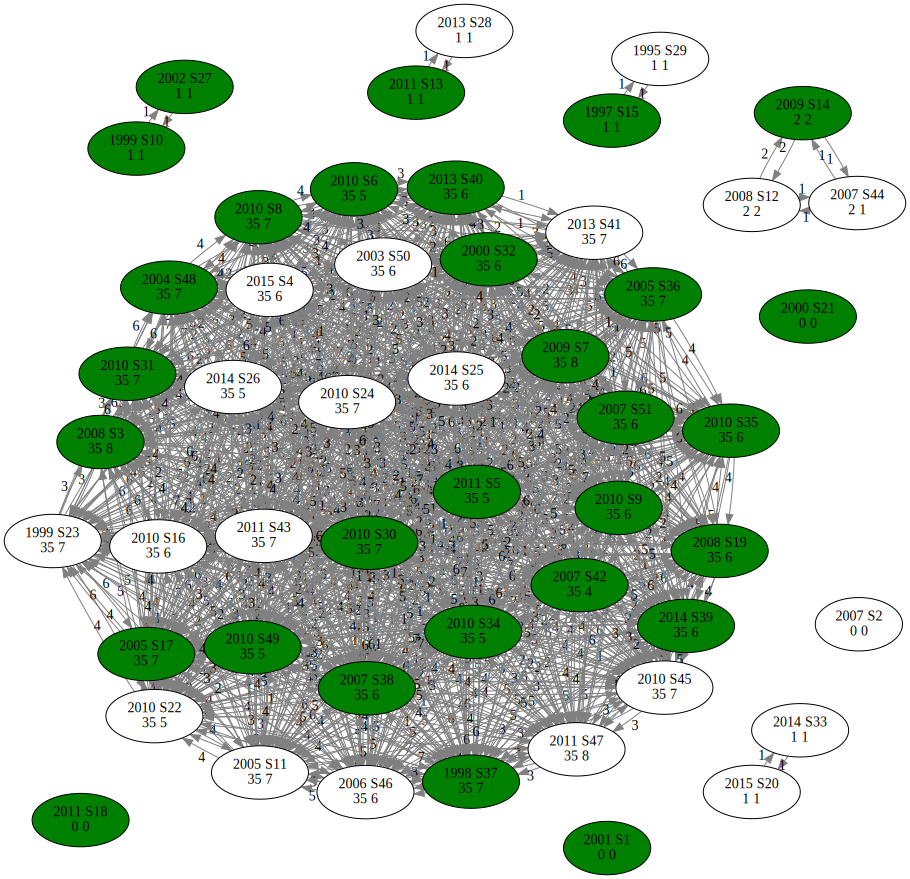

In [21]:
from subprocess import Popen, PIPE as P
class ViewMatrix:
    def __init__(self, nmatrix, names):
        self.nmatrix = nmatrix
        self.names = names
        
    @property
    def dot(self):
        text = ["digraph G {", "graph [ overlap=false ]"]
        for i, name in enumerate(self.names):
            filtered = [x for j, x in enumerate(self.nmatrix[i]) if x != float('inf') if j != i]
            total = sum(1 for x in filtered)
            maxsteps = max(filtered) if filtered else 0
            work = work_by_varname(id_to_varname[int(self.names[i].split()[-1][1:]) - 1])
            color = "green" if getattr(work, 'final_selected', 0) else "white"
            text.append(f'"{name}" [fillcolor="{color}", style=filled, label="{name}\n{total} {maxsteps}"];')
        for i, lis in enumerate(self.nmatrix):
            for j, v in enumerate(lis):
                if v != float('inf') and j != i:
                    text.append('"{}" -> "{}" [label="{}" color="gray"]'.format(self.names[i], self.names[j], v))
        text.append("}")
        return '\n'.join(text)

    def _ipython_display_(self):
        from IPython.display import display
        bundle = {}

        dot = self.dot
        bundle['text/vnd.graphviz'] = dot

        try:
            kwargs = {} if os.name != 'nt' else {"creationflags": 0x08000000}
            p = Popen(['neato', '-T', "svg", "-Goutputorder=edgesfirst"], stdout=P, stdin=P, stderr=P, **kwargs)
            image = p.communicate(dot.encode('utf-8'))[0]
            bundle['image/svg+xml'] = image.decode("utf-8")
        except OSError as e:
            print(e)
            if e.errno != os.errno.ENOENT:
                raise

        display(bundle, raw=True)
m = ViewMatrix(nmatrix, names)
m

In [10]:
strategy = Strategy({})
matrix2 = [[
    "S", "varname", "visits", "steps",
    "total backward", "selected backward",
    "total forward", "selected forward",
    "backward list", "selected backward list",
    "forward list", "selected forward list"
] + ["Step {}".format(i + 1) for i in range(pmax)]]
for varname, index in order.items():
    work = work_by_varname(varname)
    backward = strategy.ref[work]
    selected_backward = [x for x in backward if x.category == "snowball"]
    forward = strategy.rev_ref[work]
    selected_forward = [x for x in forward if x.category == "snowball"]
    steps = [[] for x in range(pmax)]
    for i, v in enumerate(nmatrix[index]):
        if v != float('inf'):
            steps[v - 1].append(id_to_varname[i])
    steps = [", ".join(s) for s in steps]
    filtered = [x for j, x in enumerate(nmatrix[index]) if x != float('inf') if j != i]
    total = sum(1 for x in filtered)
    maxsteps = max(filtered) if filtered else 0
    row = [
        "S{}".format(index + 1), varname,
        total, maxsteps,
        len(backward), len(selected_backward),
        len(forward), len(selected_forward),
        ", ".join(x.metakey for x in backward),
        ", ".join(x.metakey for x in selected_backward),
        ", ".join(x.metakey for x in forward),
        ", ".join(x.metakey for x in selected_forward),
    ] + steps
    
    matrix2.append(row)
pd.set_option('display.max_colwidth',50)
pd.set_option('display.max_colwidth',1000)
df = pd.DataFrame(matrix2)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,S,varname,visits,steps,total backward,selected backward,total forward,selected forward,backward list,selected backward list,forward list,selected forward list,Step 1,Step 2,Step 3,Step 4,Step 5,Step 6,Step 7,Step 8
1,S1,waina2001a,1,0,26,0,2,0,"whitney1994a, dunaway1996a, dedolph1994a, team2000a, humphrey1989a, hefner1999a, caputo1997a, humphrey1999a, caputo1999a, caputo1999a, waina2000a, associates1996a, davis2000a, ferguson1998a, wigle1999a, rifkin1990a, eagen1999a, waina2001b, kaplan1992a, austin1996a, jones2001a, florac1997a, park1996a, perkins2001a, zuse1998a, dekkers1999a",,"dounos2010a, ye2010a",,,,,,,,,waina2001a
2,S2,wilkie2007a,1,0,20,0,10,0,"anacleto2004a, anacleto2004b, chrissis2003a, cignoni1999a, cspt2003a, institute2005a, iso2006a, ISOIEC2006a, makinen2000a, caffery2005a, caffery2004a, mcfall2003a, mcfeeley1996a, rout2001a, paulk1995a, team2007a, sei2004a, sei2005a, wilkie2004a, wilkie2005a",,"napier2009a, lester2010a, laporte2009a, zarour2009a, sánchez2016a, lester2007a, al2013a, zarour2011a, zarour2009b, taylor2009a",,,,,,,,,wilkie2007a
3,S3,becker2008a,35,8,24,2,1,0,"akao1990a, biró1999a, brodman1995a, chrissis2003a, cox1992a, mccoy1998a, debou1999a, dyba2005a, grady1997a, hierholzer1998a, humphrey1989b, isoiec2003a, liu2005a, montoni2007a, niazi2003a, paulk1993a, peterson1995a, pitterman2000a, pulford1996a, weber2005a, yamamura1999a, yin2003a, zahran1998a, zaijun2005a","mccoy1998a, liu2005a",spósito2016a,,"liu2005a, mccoy1998a","becker2008b, sun2010a","barreto2010a, messnarz1999a, armbrust2010a, armbrust2010b, liu2006a","mcloughlin2010a, basili2007b, birkhölzer2011a","kaneko2011a, mandić2010b, unterkalmsteiner2014a, debou2000a, mcloughlin2010b, kowalczyk2010a","petersen2015a, basili2010a, mandić2010a, trienekens2005a, cocozza2014a, basili2007a, trendowicz2014a, münch2013c, trienekens2004a, murugappan2003a, basili2007c","guzmán2010a, wang2005a, mandić2010d, münch2013a, trendowicz2011a","becker2008a, trienekens2009a"
4,S4,petersen2015a,35,6,57,8,11,0,"ali2012a, ardimento2006a, baca2013a, basili2007a, basili2010a, basili1984a, boyd2002a, boyd2005a, briand1996a, brydon2003a, bühne2005a, basili1994a, colombo2003a, damm2006a, davis2006a, dieste2011a, finke2011a, gencel2013a, graham2009a, guest2006a, isoiec2002a, ivarsson2011a, iversen2004a, münch2013a, münch2013c, kaneko2011a, kaplan1996a, keele2007a, kilpl2001a, mandić2010f, mandić2010b, mandić2010c, mandić2010d, mcgarry2002a, mendonça2000a, jm1994a, mujtaba2011a, j2008a, offen1997a, park1996b, petersen2013a, petersen2009a, petersen2009b, petersen2010a, petersen2010b, petersen2011a, poppendieck2003a, runeson2009a, runeson2012a, sarcia2010a, scholtes2003a, tahir2011a, trendowicz2011a, linden2007a, latum1998a, wilson2002a, yin2011a","basili2007a, basili2010a, münch2013a, münch2013c, kaneko2011a, mandić2010b, mandić2010d, trendowicz2011a","petersen2014a, tahir2016a, trinkenreich2017a, lópez2016a, mandić2017a, roditi2014a, mughal2017a, li2017a, petersen2016a, trinkenreich2017b, minhas2017a",,"kaneko2011a, basili2010a, mandić2010b, mandić2010d, basili2007a, münch2013c, münch2013a, trendowicz2011a","guzmán2010a, mandić2010a, cocozza2014a, unterkalmsteiner2014a, trendowicz2014a, basili2007b, kowalczyk2010a, basili2007c","barreto2010a, trienekens2009a, debou2000a, murugappan2003a","wang2005a, trienekens2005a, becker2008b, mcloughlin2010a, trienekens2004a","messnarz1999a, sun2010a, armbrust2010a, mcloughlin2010b, liu2005a, mccoy1998a, armbrust2010b, liu2006a","becker2008a, birkhölzer2011a",,petersen2015a
5,S5,kaneko2011a,35,5,11,2,15,1,"kathuria2007a, basili2007b, basili2009a, basili1992a, kowalczyk2010a, isaca2005a, isaca2008a, ogc2002a, kaplan1992a, becker1999a, jaxa2012a","basili2007b, kowalczyk2010a","kobori2014a, aoki2016a, kobori2016a, razón2014a, trinkenreich2017a, lópez2016a, mandić2017a, trinkenreich2015a, heidrich2012a, asghari2012a, watanabe2017a, razón2014b, teixeira2013a, tomaz2017a, petersen2015a",petersen

In [19]:
df.to_excel("tabela_grafo.xlsx")

In [24]:
nmatrix[13]

[inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 2,
 inf,
 0,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 1,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf]